<a href="https://colab.research.google.com/github/Clizzyvibes/Coventry-University/blob/main/Pyspark_work/Copy_of_Assignmet_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install findspark pyspark

In [ ]:
# !pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Importing necessary libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import udf, explode, col, regexp_replace, isnan, when, count
from pyspark.sql.types import IntegerType,StringType,ArrayType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

##  Initializing Spark Session

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder.appName('Video_Game_Sales_Analysis').getOrCreate()

##  Reading the dataset from the provided path.
> Schema for the Dataset is inferred from the dataset, it defined to adjust the column names

[Link to dataset(fix)](https://www.kaggle.com)


In [ ]:
# Load the CSV
# df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/datasets/Video_Game_Sales_as_of_Jan_2017.csv")

df = spark.read.csv("/content/drive/MyDrive/Dataset/Video_Game_Sales_as_of_Jan_2017.csv", header=True, inferSchema=True)

# Check schema
df.printSchema()

# View sample data
df.show(5)


root
 |-- Name: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Year_of_Release: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- NA_Sales: double (nullable = true)
 |-- EU_Sales: double (nullable = true)
 |-- JP_Sales: double (nullable = true)
 |-- Other_Sales: double (nullable = true)
 |-- Global_Sales: double (nullable = true)
 |-- Critic_Score: integer (nullable = true)
 |-- Critic_Count: integer (nullable = true)
 |-- User_Score: double (nullable = true)
 |-- User_Count: integer (nullable = true)
 |-- Rating: string (nullable = true)

+--------------------+--------+---------------+------------+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+------+
|                Name|Platform|Year_of_Release|       Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|Rating|
+----------------

### Looking through the data to note column headers, data types and gain brief insights

In [ ]:
df.describe()


DataFrame[summary: string, Name: string, Platform: string, Year_of_Release: string, Genre: string, Publisher: string, NA_Sales: string, EU_Sales: string, JP_Sales: string, Other_Sales: string, Global_Sales: string, Critic_Score: string, Critic_Count: string, User_Score: string, User_Count: string, Rating: string]

In [ ]:
# Obtain summary statistics of the dataset to understand distributions and central tendencies
df.describe().show()

+-------+--------------------+--------+----------------+--------+---------------+-------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+-----------------+-----------------+------+
|summary|                Name|Platform| Year_of_Release|   Genre|      Publisher|           NA_Sales|           EU_Sales|           JP_Sales|         Other_Sales|      Global_Sales|      Critic_Score|      Critic_Count|       User_Score|       User_Count|Rating|
+-------+--------------------+--------+----------------+--------+---------------+-------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+-----------------+-----------------+------+
|  count|               17416|   17416|           17416|   17416|          17416|              17416|              17416|              17416|               17416|             17416|              8336|           

In [ ]:
df.columns

['Name',
 'Platform',
 'Year_of_Release',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales',
 'Critic_Score',
 'Critic_Count',
 'User_Score',
 'User_Count',
 'Rating']

In [ ]:
print(f"Total Rows: {df.count()}, Total Columns: {len(df.columns)}")

Total Rows: 17416, Total Columns: 15


In [ ]:
# Just view some specific columns
df.describe(["Global_Sales", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Critic_Score"]).show()

+-------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+
|summary|      Global_Sales|           NA_Sales|           EU_Sales|           JP_Sales|         Other_Sales|      Critic_Score|
+-------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+
|  count|             17416|              17416|              17416|              17416|               17416|              8336|
|   mean|0.5164693385393454|0.25453433624255806|0.14072691777678983|0.07501952227835873|0.045908360128610576| 68.91254798464492|
| stddev|1.5261242430619453| 0.8006725432963725| 0.4973405123808981| 0.3034121574957835| 0.18393217204414708|13.964937013983752|
|    min|              0.01|                0.0|                0.0|                0.0|                 0.0|                13|
|    max|             82.54|              41.36|              28.96|              10.22|         

In [ ]:
df.groupBy("Publisher").sum("Global_Sales").orderBy("sum(Global_Sales)", ascending=False).show(10)

+--------------------+------------------+
|           Publisher| sum(Global_Sales)|
+--------------------+------------------+
|            Nintendo|1802.9999999999984|
|     Electronic Arts|1132.4299999999919|
|          Activision| 739.9799999999988|
|Sony Computer Ent...| 614.2499999999985|
|             Ubisoft| 477.2999999999989|
|Take-Two Interactive| 408.6899999999997|
|                 THQ| 345.5099999999991|
|Konami Digital En...|286.00999999999755|
|                Sega|272.18999999999886|
|  Namco Bandai Games|258.83999999999776|
+--------------------+------------------+
only showing top 10 rows



##  Data preprocessing
> For the clustering, we select numerical columns that capture sales and review scores. And then ensure that rows with null values in these features are dropped.

>  I did two clustering one where all numerical values where selected and another where just few values where selected; they are both labeled clustering_data_1 and clustering_data_2 respectively...

In [ ]:
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+------+
|Name|Platform|Year_of_Release|Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|Rating|
+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+------+
|   0|       0|              0|    0|        0|       0|       0|       0|          0|           0|        9080|        9080|      9618|      9618|  7164|
+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+------+



In [ ]:
#  |-- Name: string (nullable = true)
#  |-- Platform: string (nullable = true)
#  |-- Year_of_Release: string (nullable = true)
#  |-- Genre: string (nullable = true)
#  |-- Publisher: string (nullable = true)
#  |-- NA_Sales: double (nullable = true)
#  |-- EU_Sales: double (nullable = true)
#  |-- JP_Sales: double (nullable = true)
#  |-- Other_Sales: double (nullable = true)
#  |-- Global_Sales: double (nullable = true)
#  |-- Critic_Score: integer (nullable = true)
#  |-- Critic_Count: integer (nullable = true)
#  |-- User_Score: double (nullable = true)
#  |-- User_Count: integer (nullable = true)
#  |-- Rating: string (nullable = true)

In [ ]:
# Select features for clustering_1
columns_for_clustering_data_1 = [
    "NA_Sales", "EU_Sales", "JP_Sales",
    "Other_Sales", "Global_Sales",
    "Critic_Score", "Critic_Count",
    "User_Score", "User_Count"
]

In [ ]:
# Select features for clustering_2
columns_for_clustering_data_2 = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Critic_Score"]

In [ ]:
clustering_data_1 = df.select(*columns_for_clustering_data_1).na.drop()

In [ ]:
# number of rows after removing nan values in clustering_data_1
clustering_data_1.count()

7191

In [ ]:
clustering_data_2 = df.select(*columns_for_clustering_data_2).na.drop()

In [ ]:
# number of rows after removing nan values in clustering_data_2
clustering_data_2.count()

8336

##  Feature Scaling:
> Scaling is essential for clustering because it prevents features on larger scales from dominating.

### Step 1: Assemble features
> combines multiple numeric columns into a single vector column, it provides ease of use with many ML models on spark

In [ ]:
assembler1 = VectorAssembler(inputCols=columns_for_clustering_data_1, outputCol="features")
df_vector_1 = assembler1.transform(df.na.drop(subset=columns_for_clustering_data_1))


In [ ]:
assembler2 = VectorAssembler(inputCols=columns_for_clustering_data_2, outputCol="features")
df_vector_2 = assembler2.transform(df.na.drop(subset=columns_for_clustering_data_2))


### Step 2: Scale features
>  Normalize values for fair clustering

In [ ]:
# clustering 1
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model_1 = scaler.fit(df_vector_1)
df_scaled_1 = scaler_model_1.transform(df_vector_1)

In [ ]:
# clustering 2
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model_2 = scaler.fit(df_vector_2)
df_scaled_2 = scaler_model_2.transform(df_vector_2)

##  Clustering with KMeans:
> We choose k = 4 clusters as a starting point as the data is large. This parameter can be tuned later

In [ ]:
# Applying kmeans clustering
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="prediction")

In [ ]:
# For clustering 1
model_1 = kmeans.fit(df_scaled_1)

# Make predictions
predictions_1 = model_1.transform(df_scaled_1)

# Show cluster assignment
predictions_1.select("Name", "features", "prediction").show(10)

+--------------------+--------------------+----------+
|                Name|            features|prediction|
+--------------------+--------------------+----------+
|          Wii Sports|[41.36,28.96,3.77...|         1|
|      Mario Kart Wii|[15.68,12.8,3.79,...|         0|
|   Wii Sports Resort|[15.61,10.95,3.28...|         1|
|New Super Mario B...|[11.28,9.15,6.5,2...|         1|
|            Wii Play|[13.96,9.18,2.93,...|         1|
|New Super Mario B...|[14.48,6.95,4.7,2...|         0|
|       Mario Kart DS|[9.71,7.48,4.13,1...|         1|
|             Wii Fit|[8.92,8.03,3.6,2....|         1|
|  Kinect Adventures!|[15.02,4.91,0.24,...|         1|
|        Wii Fit Plus|[9.01,8.49,2.53,1...|         1|
+--------------------+--------------------+----------+
only showing top 10 rows



In [ ]:
# For clustering 2
model_2 = kmeans.fit(df_scaled_2)

# Make predictions
predictions_2 = model_2.transform(df_scaled_2)

# Show cluster assignment
predictions_2.select("Name", "features", "prediction").show(10)

+--------------------+--------------------+----------+
|                Name|            features|prediction|
+--------------------+--------------------+----------+
|          Wii Sports|[41.36,28.96,3.77...|         1|
|      Mario Kart Wii|[15.68,12.8,3.79,...|         1|
|   Wii Sports Resort|[15.61,10.95,3.28...|         1|
|New Super Mario B...|[11.28,9.15,6.5,2...|         1|
|            Wii Play|[13.96,9.18,2.93,...|         0|
|New Super Mario B...|[14.48,6.95,4.7,2...|         1|
|       Mario Kart DS|[9.71,7.48,4.13,1...|         1|
|             Wii Fit|[8.92,8.03,3.6,2....|         1|
|  Kinect Adventures!|[15.02,4.91,0.24,...|         0|
|        Wii Fit Plus|[9.01,8.49,2.53,1...|         1|
+--------------------+--------------------+----------+
only showing top 10 rows




##  Evaluate the Clustering:
> The Silhouette Score helps us understand how well the clusters are separated.


In [ ]:
# For Clustering 1
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(
    featuresCol="features", predictionCol="prediction",
    metricName="silhouette", distanceMeasure="squaredEuclidean"
)

silhouette = evaluator.evaluate(predictions_1)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9431224301712804


In [ ]:
# For Clustering 2
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(
    featuresCol="features", predictionCol="prediction",
    metricName="silhouette", distanceMeasure="squaredEuclidean"
)

silhouette = evaluator.evaluate(predictions_2)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6857371788907861


## Displaying the Cluster Centers

>

In [ ]:
centers = model_1.clusterCenters()
print("Cluster_1 Centers: ")
for center in centers:
    print(center)

Cluster_1 Centers: 
[1.04272512e+00 7.48744076e-01 1.76161137e-01 2.66824645e-01
 2.23426540e+00 8.33767773e+01 5.16990521e+01 7.44431280e+00
 9.84507109e+02]
[3.16859032e-01 1.76734295e-01 5.41959723e-02 6.22542831e-02
 6.10281034e-01 6.90834085e+01 2.64983469e+01 7.15772468e+00
 5.99400361e+01]
[1.45235294e+00 1.24705882e+00 6.94117647e-02 3.87058824e-01
 3.15588235e+00 8.97058824e+01 6.11764706e+01 6.74705882e+00
 7.88094118e+03]
[1.97020408e+00 1.49336735e+00 1.21428571e-01 4.71836735e-01
 4.05673469e+00 8.70102041e+01 6.54897959e+01 7.19897959e+00
 3.11369388e+03]


In [ ]:
centers = model_2.clusterCenters()
print("Cluster_2 Centers: ")
for center in centers:
    print(center)

Cluster_2 Centers: 
[1.76642259e-01 8.83054393e-02 1.93253138e-02 3.03870293e-02
 5.72055439e+01]
[ 0.64484375  0.40242369  0.10987645  0.13971294 83.31213663]
[1.27210243e-01 5.59433962e-02 6.46900270e-03 2.03504043e-02
 4.00781671e+01]
[2.38467577e-01 1.36948805e-01 3.75494881e-02 4.75358362e-02
 7.03293515e+01]


##  Saving prediction cluster values for analysis

In [ ]:
# saving predictions for further use for Tableau visualization
predictions_1.select("prediction", *columns_for_clustering_data_1).write.csv("clustered_data_1_video_game_sales.csv", header=True)

In [ ]:
# saving predictions for further use for Tableau visualization
predictions_2.select("prediction", *columns_for_clustering_data_2).write.csv("clustered_data_2_video_game_sales.csv", header=True)

## Basic plots to gain insights

> I would convert from Spark Dataframe to Pandas for ease of visualizations

#### Cluster_1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
# Verify that my clusters make sense.
# Select relevant columns (including cluster prediction)
columns_to_plot = columns_for_clustering_data_1 + ["prediction"]

# Convert Spark DataFrame to Pandas DataFrame
plot_df = predictions_1.select(columns_to_plot).toPandas()

In [ ]:
plot_df = predictions_1.select(columns_to_plot).sample(fraction=0.2).toPandas()  # 20% sample

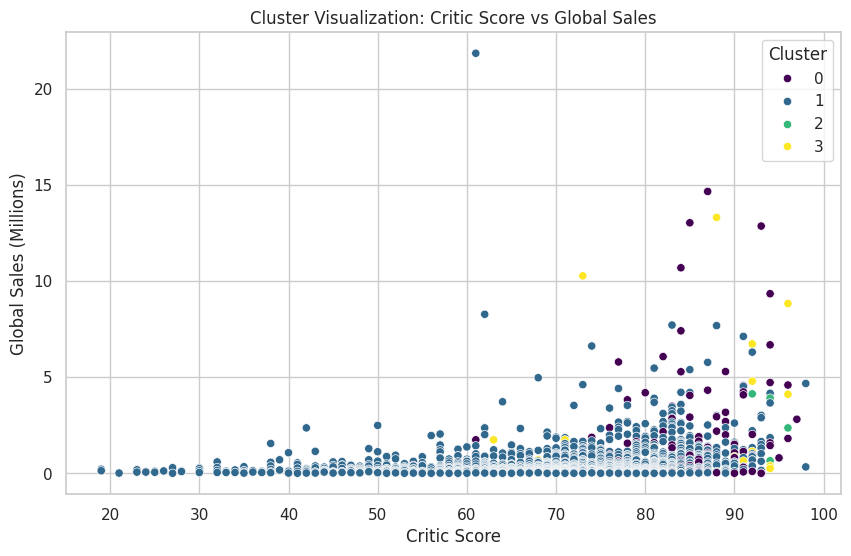

In [ ]:
# Cluster Visualisation (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x="Critic_Score", y="Global_Sales", hue="prediction", palette="viridis")
plt.title("Cluster Visualization: Critic Score vs Global Sales")
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (Millions)")
plt.legend(title="Cluster")
plt.show()


<ipython-input-40-037a805bf1a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="prediction", y="Global_Sales", palette="Set2")


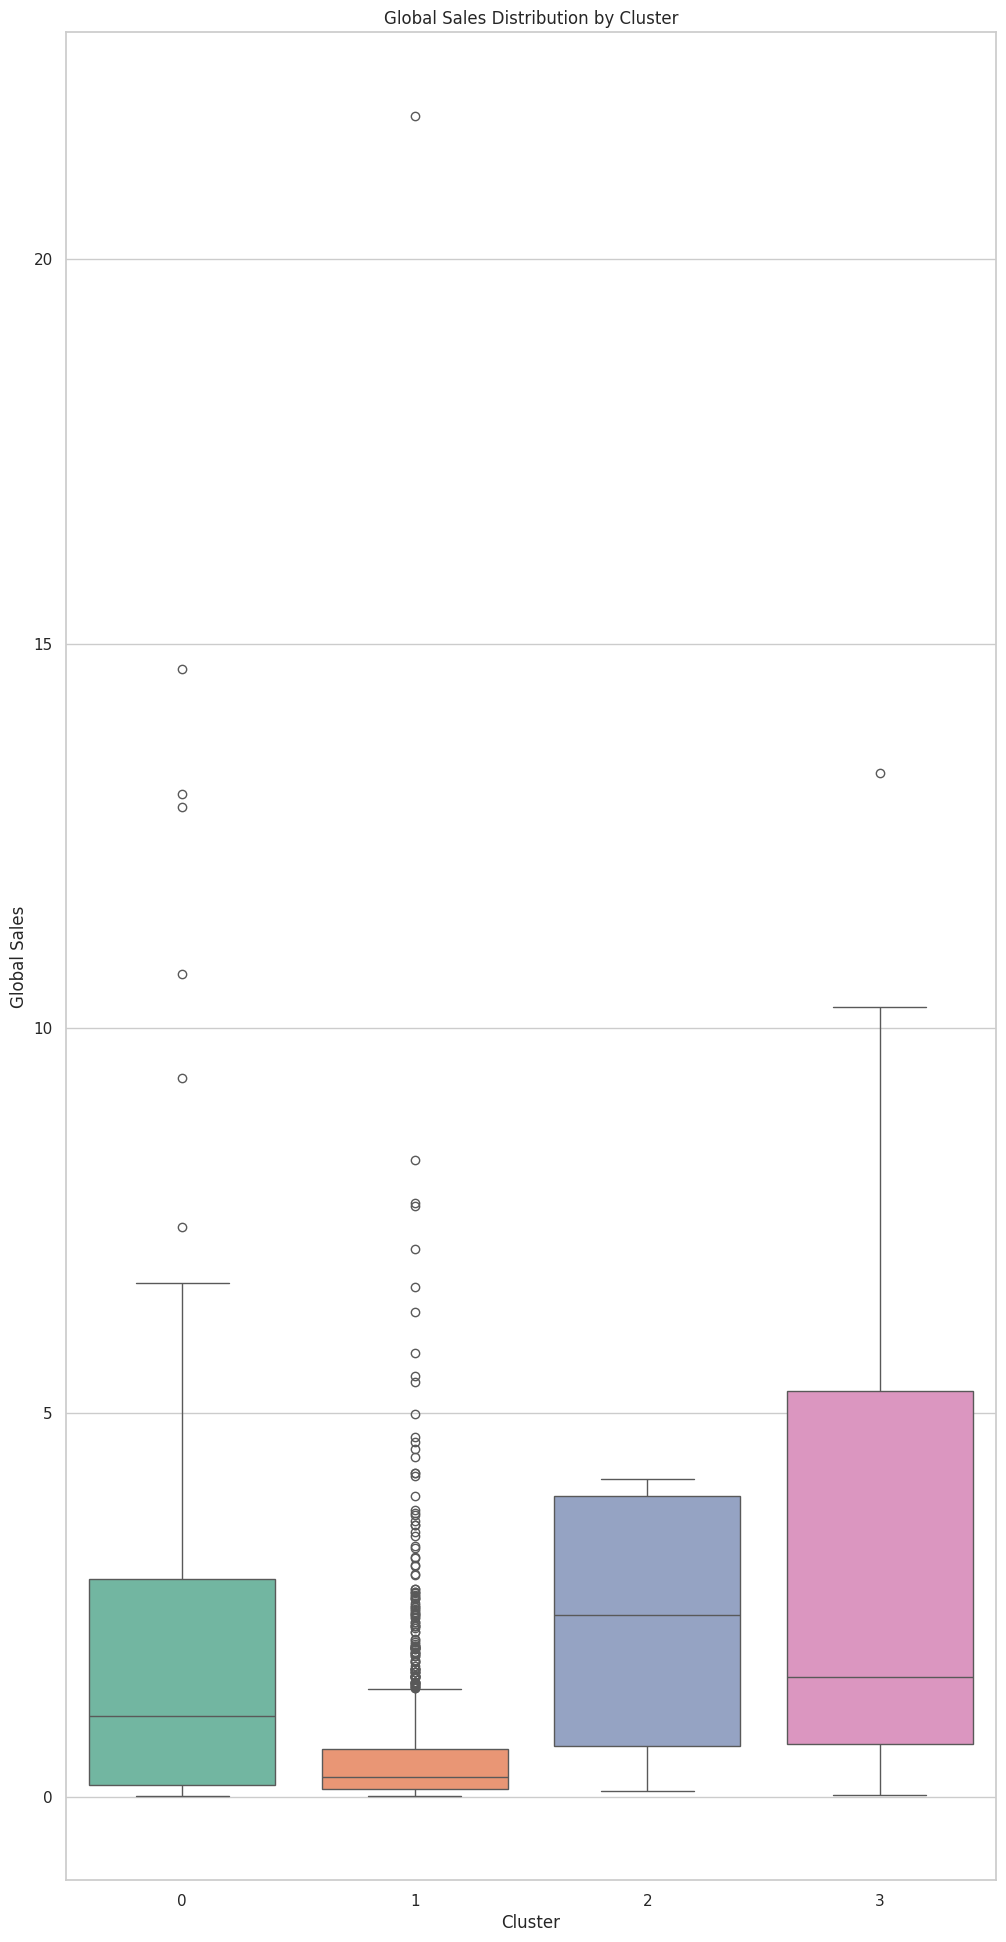

In [ ]:
# Sales Distribution by Cluster
plt.figure(figsize=(12, 24))
sns.boxplot(data=plot_df, x="prediction", y="Global_Sales", palette="Set2")
plt.title("Global Sales Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Global Sales")
plt.show()


<ipython-input-41-7abc39307618>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=plot_df, x="prediction", palette="coolwarm")


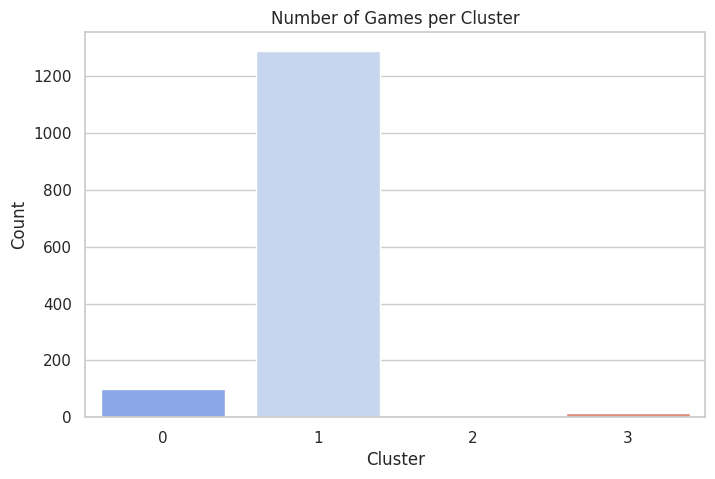

In [ ]:
# Cluster Count
plt.figure(figsize=(8, 5))
sns.countplot(data=plot_df, x="prediction", palette="coolwarm")
plt.title("Number of Games per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


#### Cluster_2

In [ ]:
# Verify that my clusters make sense.
# Select relevant columns (including cluster prediction)
columns_to_plot = columns_for_clustering_data_2 + ["prediction"]

# Convert Spark DataFrame to Pandas DataFrame
plot_df = predictions_2.select(columns_to_plot).toPandas()

In [ ]:
plot_df = predictions_2.select(columns_to_plot).sample(fraction=0.2).toPandas()  # 20% sample

In [ ]:
print(columns_to_plot)

['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score', 'prediction']


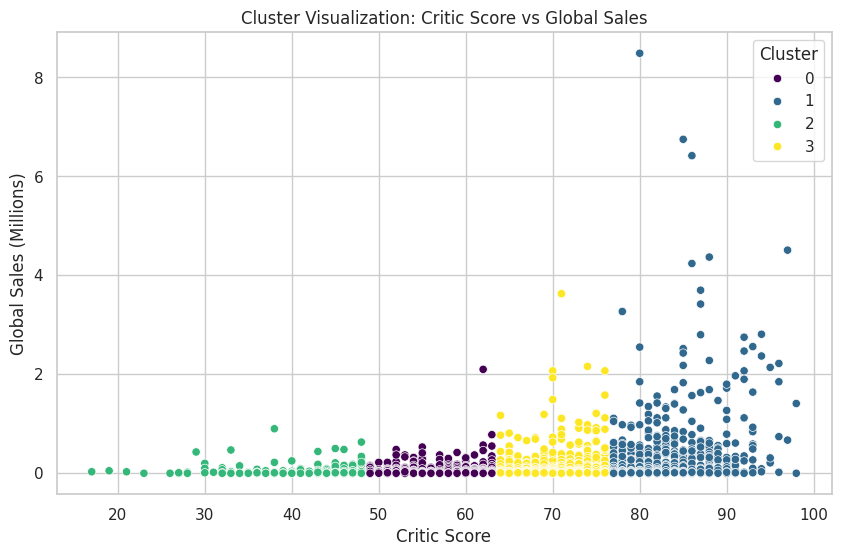

In [ ]:
# Cluster Visualisation (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x="Critic_Score", y="EU_Sales", hue="prediction", palette="viridis")
plt.title("Cluster Visualization: Critic Score vs Global Sales")
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (Millions)")
plt.legend(title="Cluster")
plt.show()


<ipython-input-46-41cd65f73f65>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="prediction", y="EU_Sales", palette="Set2")


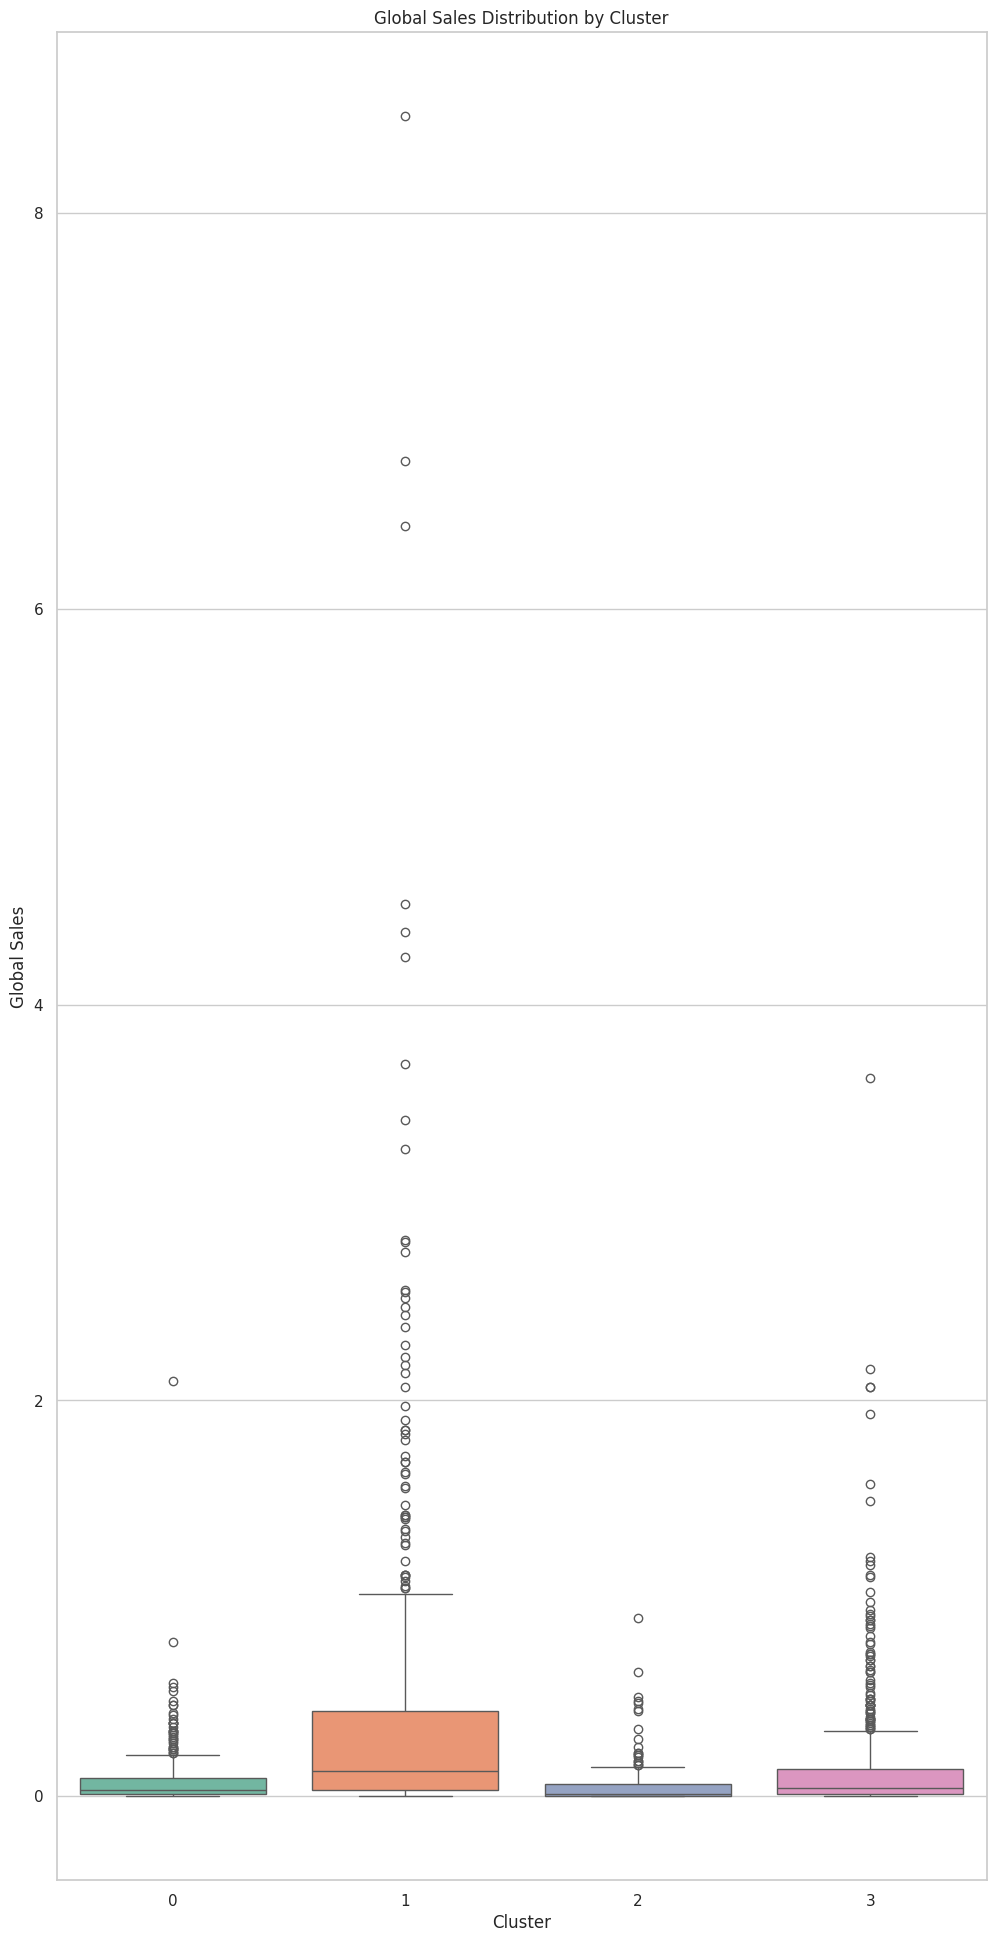

In [ ]:
# Sales Distribution by Cluster
plt.figure(figsize=(12, 24))
sns.boxplot(data=plot_df, x="prediction", y="EU_Sales", palette="Set2")
plt.title("Global Sales Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Global Sales")
plt.show()


<ipython-input-47-7abc39307618>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=plot_df, x="prediction", palette="coolwarm")


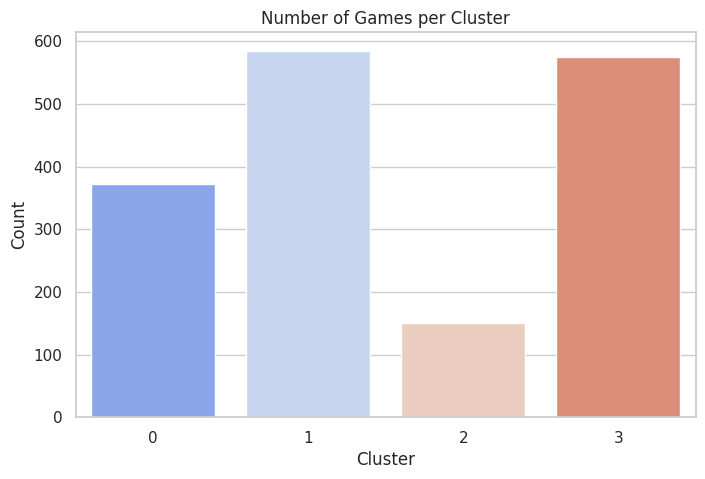

In [ ]:
# Cluster Count
plt.figure(figsize=(8, 5))
sns.countplot(data=plot_df, x="prediction", palette="coolwarm")
plt.title("Number of Games per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()
